# Setup

In [61]:
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

from datasets import load_dataset
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score

import os
import pickle

Since we are operating on a Mac with M2 chip, CUDA is not available. However, we can get GPU acceleration like this:

In [3]:
print("CUDA?            ", torch.cuda.is_available())

print("MPS available?   ", torch.backends.mps.is_available()) #the MacOS is higher than 12.3+
print("MPS built?       ", torch.backends.mps.is_built()) #MPS is activated

device = torch.device("mps")
print("Device:          ", device)

CUDA?             False
MPS available?    True
MPS built?        True
Device:           mps


# EDA

First, we will load the dataset: https://huggingface.co/datasets/dair-ai/emotion

In [4]:
emotions = load_dataset("emotion")

No config specified, defaulting to: emotion/split
Found cached dataset emotion (/Users/david/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
train_ds = emotions["train"]
val_ds = emotions["validation"]
test_ds = emotions["test"]

print(train_ds.features)
print()
print(train_ds[:5])

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


Next, we will buid a DataFrame to use for further data analysis.

In [7]:
emotions.set_format("pandas")
df = emotions["train"][:]

label_dict = {
    id:label for id, label in enumerate(['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])
    }

df["label_names"] = df["label"].map(lambda x: label_dict[x])

df

text  label label_names
0                                i didnt feel humiliated      0     sadness
1      i can go from feeling so hopeless to so damned...      0     sadness
2       im grabbing a minute to post i feel greedy wrong      3       anger
3      i am ever feeling nostalgic about the fireplac...      2        love
4                                   i am feeling grouchy      3       anger
...                                                  ...    ...         ...
15995  i just had a very brief time in the beanbag an...      0     sadness
15996  i am now turning and i feel pathetic that i am...      0     sadness
15997                     i feel strong and good overall      1         joy
15998  i feel like this was such a rude comment and i...      3       anger
15999  i know a lot but i feel so stupid because i ca...      0     sadness

[16000 rows x 3 columns]

Now, we can check class imbalances (and resample if necessary) and also text lengths.

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: label_names, dtype: int64


<Axes: xlabel='label_names', ylabel='Count'>

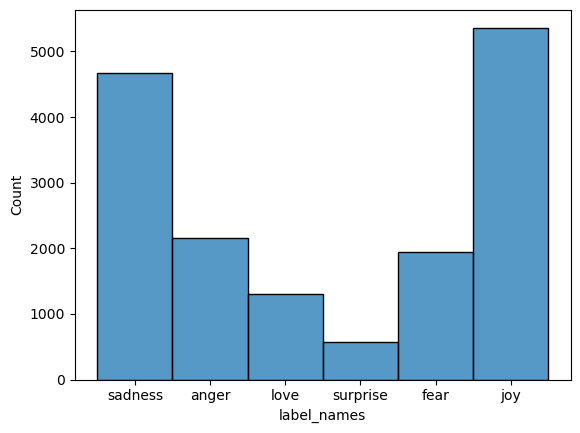

In [8]:
print(df.label_names.value_counts())
sns.histplot(df.label_names)

We might consider upsampling for the minority classes if the performance is hindered!

<Axes: title={'center': 'word_count'}, xlabel='label_names'>

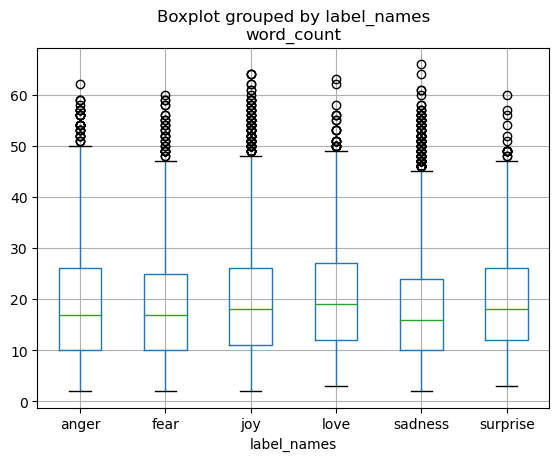

In [9]:
df["word_count"] = df.text.apply(lambda x: len(x.split()))

df.boxplot(column="word_count", by="label_names", showfliers=True)

There is no tweet longer than 70 words - this easily fits into the context size of our model.

In [10]:
emotions.reset_format()

# Loading Pre-Trained Models

https://huggingface.co/distilbert-base-uncased

In [11]:
model_checkpoint = "distilbert-base-uncased"
num_labels = 6

tokenizer = DistilBertTokenizer.from_pretrained(model_checkpoint)
model = DistilBertForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifi

In [12]:
tokenizer

DistilBertTokenizer(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [13]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [14]:
type(model)

transformers.models.distilbert.modeling_distilbert.DistilBertForSequenceClassification

We place the model on the GPU:

In [15]:
model.to(device)
print(model.device)

mps:0


We can tokenize and detokenize a single data point like this:

In [16]:
ex_text_orig = train_ds[0]['text']
print(ex_text_orig)

ex_encoded_text = tokenizer(train_ds[0]['text'])
print(ex_encoded_text)

ex_tokens = tokenizer.convert_ids_to_tokens(ex_encoded_text.input_ids)
print(ex_tokens)

ex_string_recon = tokenizer.convert_tokens_to_string(ex_tokens)
print(ex_string_recon)

i didnt feel humiliated
{'input_ids': [101, 1045, 2134, 2102, 2514, 26608, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}
['[CLS]', 'i', 'didn', '##t', 'feel', 'humiliated', '[SEP]']
[CLS] i didnt feel humiliated [SEP]


Running a forward pass through the model with a batch of tokenized data points:

In [17]:
ex_model_inputs = tokenizer(train_ds[:64]['text'], return_tensors="pt", padding=True).to(device)
ex_model_outputs = model(**ex_model_inputs)

print(ex_model_inputs)
print(ex_model_outputs)

{'input_ids': tensor([[  101,  1045,  2134,  ...,     0,     0,     0],
        [  101,  1045,  2064,  ...,     0,     0,     0],
        [  101, 10047,  9775,  ...,     0,     0,     0],
        ...,
        [  101,  1045,  8823,  ...,     0,     0,     0],
        [  101,  1045,  2514,  ...,     0,     0,     0],
        [  101,  1045,  2211,  ...,     0,     0,     0]], device='mps:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='mps:0')}
SequenceClassifierOutput(loss=None, logits=tensor([[ 1.4233e-01, -3.5799e-02, -3.9052e-02, -1.2486e-01,  1.1337e-02,
          4.1456e-03],
        [ 1.5962e-01, -1.8645e-03, -5.0531e-02, -1.1383e-01,  1.6687e-02,
         -1.2262e-02],
        [ 1.4096e-01, -2.8270e-02, -2.3139e-02, -1.4966e-01, -5.5413e-03,
         -3.0725e-04],
        [ 1.2116e-01

/Users/david/miniforge3/envs/hugging/lib/python3.9/site-packages/torch/_tensor_str.py:115: UserWarning: MPS: nonzero op is supported natively starting from macOS 13.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1682343673238/work/aten/src/ATen/native/mps/operations/Indexing.mm:218.)
  nonzero_finite_vals = torch.masked_select(


Keep in mind that the output are logits, not probabilities!

In [18]:
torch.sum(ex_model_outputs.logits, dim=-1)

tensor([-0.0419, -0.0022, -0.0660, -0.0210, -0.0499, -0.0132,  0.0737, -0.0452,
        -0.1164, -0.0979, -0.0686, -0.0133, -0.0609, -0.0519, -0.0640, -0.0103,
        -0.0400, -0.0547,  0.0500, -0.1231, -0.0181, -0.0301, -0.0783, -0.0810,
         0.0055, -0.0127,  0.1546, -0.0589,  0.0117,  0.0926, -0.0358, -0.0552,
        -0.0926, -0.0279, -0.0155, -0.1053, -0.1480, -0.0624, -0.0002, -0.0189,
         0.0222, -0.0571,  0.0140, -0.0499,  0.0222, -0.1129,  0.0362, -0.0380,
         0.0428, -0.0403, -0.0626, -0.0302, -0.0944, -0.0945,  0.1283, -0.0401,
         0.0465, -0.0818, -0.0135, -0.0978, -0.0385, -0.0675, -0.0345,  0.0498],
       device='mps:0', grad_fn=<SumBackward1>)

# Creating DataLoaders

In [19]:
class TweetDataset(Dataset):
    def __init__(self, split):
        self.text = split["text"]
        self.labels = split["label"]

    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, index):
        return self.text[index], self.labels[index]

In [20]:
BATCH_SIZE = 16

train_dataset = TweetDataset(train_ds)
val_dataset = TweetDataset(val_ds)
test_dataset = TweetDataset(test_ds)

train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [21]:
ex_batch_text, ex_batch_labels = next(iter(train_data_loader)) 
ex_batch_text, ex_batch_labels

(('i feel angered and firey',
  'i feel a tender compassion glancing at her huge and heavy rucksack',
  'ive been hanging around younger people and when i am with them i feel like im but when i see the photos of us together i am suddenly shaken to see just how old i look',
  'i sometimes feel shy about my musical taste because some of it wanders towards what some might call techno slander',
  'i woke up today feeling just as thankful',
  'i feel a recipe is only a theme which an intelligent cook can play each time with a variation',
  'i am feeling very anxious about going to therapy w',
  'i no longer feel happy to score well',
  'im sitting at the spare desk feeling totally disillusioned and frustrated with my working life in general',
  'i am feeling peaceful yet determined as i listen to the slight humming noise of the ceiling fan',
  'i see myself starting to feel the emotional dependence on my parents i stop and breathe',
  'i don t mean this to be a serious recollection of feeli

In [67]:
ex_batch_labels.tolist()

[3, 2, 4, 4, 1, 1, 4, 1, 0, 1, 0, 5, 4, 2, 0, 5]

# Define Training Loop

We could run a `Trainer` object from the `transformers` library but I want to implement the loop from scratch as practice. Furthermore, the logging of training metrics is implemented on a low level, instead of using `Tensorboard` and `SummaryWriter`.

In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5, weight_decay=0.01)

def compute_metrics(logit_outputs, labels):
    preds = torch.max(F.softmax(logit_outputs, dim=-1), dim=-1)[1]
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return acc, f1

In [24]:
EPOCHS = 3

def train(
        model=model,
        train_data_loader=train_data_loader,
        val_data_loader=val_data_loader,
        tokenizer=tokenizer,
        optimizer=optimizer,
        loss_fn=loss_fn,
        epochs=EPOCHS):
    
    logs = {
        'train_losses': [],
        'train_metrics': [],
        'val_losses': [],
        'val_metrics': []
    }

    for epoch in range(EPOCHS):
        print(f"--------------- EPOCH {epoch+1} ----------------")

        # TRAIN
        train_loss_epoch = 0.0
        train_loss_iterations = []
        train_metrics_iterations = {'acc': [], 'f1': []}
        model.train()
        for i, train_batch in enumerate(train_data_loader):
            # algo 
            optimizer.zero_grad()
            inputs, labels = train_batch
            inputs = tokenizer(inputs, return_tensors='pt', padding=True, truncation=True)
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            loss.backward()
            optimizer.step()

            # logging
            train_loss_epoch += loss * inputs.input_ids.size()[0]
            train_loss_iterations.append(loss)
            acc, f1 = compute_metrics(logit_outputs=outputs.logits.cpu(), labels=labels.cpu())
            train_metrics_iterations['acc'].append(acc)
            train_metrics_iterations['f1'].append(f1)
            
            # free GPU memory
            inputs.input_ids.detach()
            inputs.attention_mask.detach()
            labels.detach()

        train_loss_epoch /= len(train_data_loader.dataset)
        train_acc_epoch = sum(train_metrics_iterations['acc']) / len(train_data_loader)
        train_f1_epoch = sum(train_metrics_iterations['f1']) / len(train_data_loader)
        print(f"Average TRAIN loss: {train_loss_epoch}")
        print(f"Average TRAIN acc: {train_acc_epoch}")
        print(f"Average TRAIN F1: {train_f1_epoch}")
        print()
        logs["train_losses"].append(train_loss_iterations)
        logs["train_metrics"].append(train_metrics_iterations)


        # VALIDATE
        val_loss_epoch = 0.0 
        val_loss_iterations = []
        val_metrics_iterations = {'acc': [], 'f1': []}
        model.eval()
        with torch.no_grad():
            for val_batch in val_data_loader:
                inputs, labels = val_batch
                inputs = tokenizer(inputs, return_tensors='pt', padding=True, truncation=True)
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(**inputs)
                loss = loss_fn(outputs.logits, labels)

                val_loss_epoch += loss * inputs.input_ids.size()[0]
                val_loss_iterations.append(loss)
                acc, f1 = compute_metrics(logit_outputs=outputs.logits.cpu(), labels=labels.cpu())
                val_metrics_iterations['acc'].append(acc)
                val_metrics_iterations['f1'].append(f1)

                inputs.input_ids.detach()
                inputs.attention_mask.detach()
                labels.detach()

            val_loss_epoch /= len(val_data_loader.dataset)
            val_acc_epoch = sum(val_metrics_iterations['acc']) / len(val_data_loader)
            val_f1_epoch = sum(val_metrics_iterations['f1']) / len(val_data_loader)
            print(f"Average VALIDATION loss: {val_loss_epoch}")
            print(f"Average VALIDATION acc: {val_acc_epoch}")
            print(f"Average VALIDATION F1: {val_f1_epoch}")
            print()
            logs["val_losses"].append(val_loss_iterations)
            logs["val_metrics"].append(val_metrics_iterations)
    
        # CHECKPOINT
        torch.save(model, f"checkpoints/model_epoch_{epoch+1}")
        
    return logs

In [25]:
history = train()

--------------- EPOCH 1 ----------------
Average TRAIN loss: 0.5427333116531372
Average TRAIN acc: 0.810875
Average TRAIN F1: 0.7868587813738663

Average VALIDATION loss: 0.19164295494556427
Average VALIDATION acc: 0.9295
Average VALIDATION F1: 0.9345529768992618

--------------- EPOCH 2 ----------------
Average TRAIN loss: 0.17533010244369507
Average TRAIN acc: 0.9329375
Average TRAIN F1: 0.9323326799152223

Average VALIDATION loss: 0.15689700841903687
Average VALIDATION acc: 0.9355
Average VALIDATION F1: 0.9365527271447162

--------------- EPOCH 3 ----------------
Average TRAIN loss: 0.16286173462867737
Average TRAIN acc: 0.9343125
Average TRAIN F1: 0.9334694767618423

Average VALIDATION loss: 0.17313864827156067
Average VALIDATION acc: 0.93
Average VALIDATION F1: 0.9266658026613909



It looks like we start to overfit within epoch 3. For further evaluation on the test set, we will load the checkpoint after epoch 2.

<Axes: >

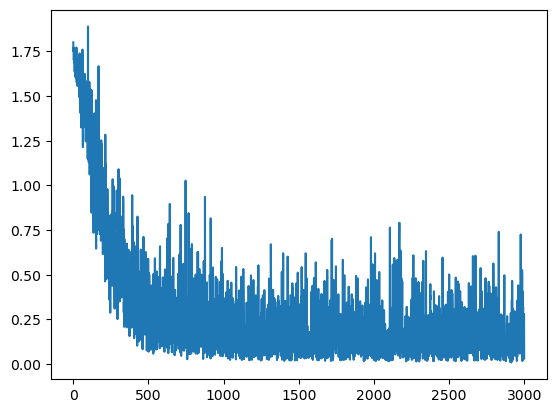

In [42]:
losses_by_iteration = []
for epoch in history["train_losses"]:
    for iteration in epoch:
        losses_by_iteration.append(iteration.data.item())

pd.Series(losses_by_iteration).plot()

# Evaluation & Error Analysis

In [43]:
trained_model = torch.load("checkpoints/model_epoch_2")

In [45]:
trained_model.device

device(type='mps', index=0)

In [58]:
def eval_on_test():
    model.eval()
    with torch.no_grad():
        test_loss = 0
        for batch in test_data_loader:
            inputs, labels = batch
            inputs = tokenizer(inputs, return_tensors='pt', padding=True, truncation=True)
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = trained_model(**inputs)
            loss = loss_fn(outputs.logits, labels)

            test_loss += loss * inputs.input_ids.size()[0]
            acc, f1 = compute_metrics(outputs.logits.cpu(), labels.cpu())

        test_loss /= len(test_data_loader.dataset)
        print("Loss on TEST: ", test_loss)
        print("Acc on TEST: ", acc)
        print("F1 on TEST: ", f1)

In [59]:
eval_on_test()

Loss on TEST:  tensor(0.1681, device='mps:0')
Acc on TEST:  0.9375
F1 on TEST:  0.9444444444444444


**93,75%** accuracy on unseen data. Let's get a better understanding of the errors the model makes on the different categories - this way we can check if the class imbalance of the dataset had a negative impact.

# Saving

In [60]:
torch.save(trained_model, "../models/model")
torch.save(tokenizer, "../models/tokenizer")

In [64]:
with open("../models/label_dict", 'wb') as file:
    pickle.dump(label_dict, file)

In [68]:
next(iter(test_data_loader)) 

[('ive been too deep down in the swamps swimming in muddy waters tortured by fear feeling lonely and lost',
  'i am feeling a little apprehensive about the whole thing',
  'i lift different now because it hurt so bad the day it happened that i can t get it out of my mind and i feel myself being a bit timid',
  'im pretty sure and its been about a week and a half so although im feeling kind of betrayed and disillusioned by men at the moment everythings okay',
  'i asked her what she meant by shes gonna feel jealous having loada of girls over me and then she said maybee i do like you a bitt',
  'i was so uncomfortable and feeling weird feelings but wasn t sure if they were contractions since i never really felt contractions with jared until they jacked me up with pitocin',
  'im not sure if im more at peace with our situation or if im just not feeling as bitter about it but in the past five months something has changed within me',
  'i feel a bit calm now',
  'i see all my friends postin